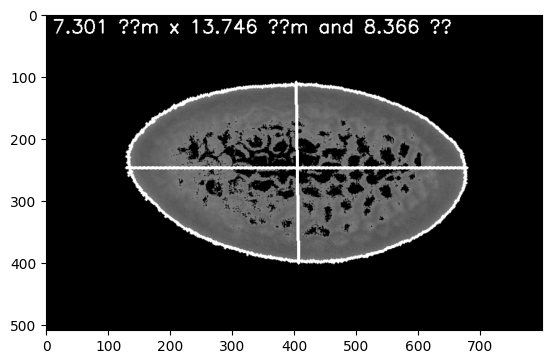

In [90]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def extractDimensions(pollenimage):
    """
    This function extracts the length, width and angle of the image.

    It starts by sharpening the image using a kernel.

    Then a binary mask and an inverse mask is created using binary thresholding.
    
    The inverse mask is applied to the image masking out the background. 

    The contours are drawn and written on the image drawing the shape/boundary of the pollen.

    Looping through the image, the left and right most points are found and used to find width.

    The angle of the line is found by using arctan2 and is used to rotate the image with a rotation matrix.

    The highest and lowest points are found and used to calculate length.

    The width and length are converted to microns and written on the image.


    """
    kernel = np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
    
    pollenimage = cv2.filter2D(pollenimage, -1, kernel)


    _,thresh = cv2.threshold(pollenimage,127,255,cv2.THRESH_BINARY)
    inverse_thresh = cv2.bitwise_not(thresh)
    pollenimage = cv2.bitwise_and(pollenimage, pollenimage, mask=inverse_thresh)



    contours, _ = cv2.findContours(pollenimage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(pollenimage, contours, -1, (255, 255, 255), 3)


    leftMostPoint = None
    rightMostPoint = None
    topMostPoint = None
    bottomMostPoint = None


    for i in range(len(pollenimage)):
        for j in range(len(pollenimage[0])):
            if pollenimage[i][j] == 255:
                if leftMostPoint is None:
                    leftMostPoint = (j, i)
                else:
                    leftMostPoint = min(leftMostPoint, (j, i))
                if rightMostPoint is None:
                    rightMostPoint = (j, i)
                else:
                    rightMostPoint = max(rightMostPoint, (j, i))

    cv2.line(pollenimage, leftMostPoint, rightMostPoint, (255, 255, 255), 3)


    angle = np.arctan2(rightMostPoint[1] - leftMostPoint[1], rightMostPoint[0] - leftMostPoint[0]) * 180 / np.pi

    rows, cols = pollenimage.shape
    rotateMatrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    pollenimage = cv2.warpAffine(pollenimage, rotateMatrix, (cols, rows))


    for i in range(len(pollenimage)):
        for j in range(len(pollenimage[0])):
            if pollenimage[i][j] == 255:
                if topMostPoint is None:
                    topMostPoint = (j, i)
                else:
                    topMostPoint = min(topMostPoint, (j, i))
                break
        if topMostPoint is not None:
            break

    for i in range(len(pollenimage)-1, -1, -1):
        for j in range(len(pollenimage[0])):
            if pollenimage[i][j] == 255:
                if bottomMostPoint is None:
                    bottomMostPoint = (j, i)
                else:
                    bottomMostPoint = max(bottomMostPoint, (j, i))
                break
        if bottomMostPoint is not None:
            break


    cv2.line(pollenimage, topMostPoint, bottomMostPoint, (255, 255, 255), 3)

    width = np.sqrt((rightMostPoint[0] - leftMostPoint[0])**2 + (rightMostPoint[1] - leftMostPoint[1])**2)
    length = np.sqrt((bottomMostPoint[0] - topMostPoint[0])**2 + (bottomMostPoint[1] - topMostPoint[1])**2)

    width_in_microns = width * 25 / 1000
    length_in_microns = length * 25 / 1000


    cv2.putText(pollenimage, f"{width_in_microns:.3f} μm x {length_in_microns:.3f} μm and {angle:.3f} °", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return pollenimage


pollenimage = cv2.imread('Pollen.jpg', 0)

img = extractDimensions(pollenimage)

plt.imshow(img, cmap='gray')
plt.show()